# Customizing CoolBox

This document is talking about how to create user-defined Track and Coverage types.

Interactive online version: [Binder](https://mybinder.org/v2/gh/GangCaoLab/CoolBox/HEAD?filepath=docs%2Fsource%2Fcustom_elements.ipynb)

CoolBox provided a lot of builtin [Track](https://github.com/GangCaoLab/CoolBox/tree/master/coolbox/core/track)
and [Coverage](https://github.com/GangCaoLab/CoolBox/tree/master/coolbox/core/coverage) types for
different kinds of genomic data formats and display form. 
But maybe these can't cover all your needs some time.

**The good news is that, it's very easy to
define new element types(Track, Coverage, Feature) in CoolBox!**

The CoolBox plot system is compitible with
[matplotlib](https://matplotlib.org/index.html) Python library, you only
need to know some basic usage of it.

In [1]:
# firstly import the coolbox, and check the version:
import sys; sys.path.insert(0, "../")
import coolbox
from coolbox.api import *
coolbox.__version__

'0.2.5'

## Custom Track

To implement a new Track, the only three thing you need to do:

1. Import the base `Track` class from `coolbox.core.base` module.
2. Create new track type, and inherit the `Track` as parent class.
3. Implement the `plot` and `fetch_data` method.

The code schema will look like this:

```Python
from coolbox.core.Track.base import Track

class MyTrack(Track):
    def __init__(self, ...):
        # Initialization
        pass
    
    def plot(self, ax, chrom, start, end):
        # Method for plot the track 
        # within the genome range "chrom:start-end".
        # Draw in the pass-in `ax` Axes 
        pass
    
    def fetch_data(self, genome_range):
        # Method for fetch the data within genome_range
        # genome_range is a string like: "chr9:4000000-6000000"
        # or a `coolbox.utilities.GenomeRange` object
        pass

```

For better understand it, here we give an example of define a simple toy track:

### Pokemon track

For example we want to plot some [pokemons](https://en.wikipedia.org/wiki/Pok%C3%A9mon)
on some genome regions, and
we have a BED like text file like this:

```
chr1	1000	2000	Bulbasaur
chr1	2000	3000	Charmander
chr1	3000	4000	Squirtle
chr1	4000	5000	Pikachu
```

We stores it in `../_static/pokemons/list.txt`.


In [2]:
!ls ../_static/pokemons

Bulbasaur.png  Charmander.png  list.txt  Pikachu.png  Squirtle.png


In [3]:
from coolbox.core.track.base import Track
from coolbox.utilities import to_gr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

class Pokemon(Track):
    
    def __init__(self, file, img_dir):
        # read the table
        self.df = pd.read_csv(file, sep="\t", header=None)
        self.df.columns = ['chrom', 'start', 'end', 'pokemon']
        # directory store the images
        self.img_dir = img_dir
        super().__init__({})  # init Track class
    
    def fetch_data(self, genome_range):
        gr = to_gr(genome_range) # force convert to GenomeRange object
        df = self.df
        sub_df = df[
            (df['chrom'] == gr.chrom) & (df['start'] >= gr.start) & (df['end'] <= gr.end)
        ]
        return sub_df
    
    def plot(self, ax, chrom, start, end):
        df = self.fetch_data(f"{chrom}:{start}-{end}")  # get data in range
        for _, row in df.iterrows():
            img_path = f"{self.img_dir}/{row['pokemon']}.png" # get image path
            im = plt.imread(img_path)
            oi = OffsetImage(im, zoom = 0.5)
            px = (row['start'] + row['end']) / 2  # X position
            py = 0 
            box = AnnotationBbox(oi, (px, py), frameon=False)
            ax.add_artist(box)
        ax.set_xlim(start, end)
        ax.set_ylim(-1, 1)

In [4]:
pkm = Pokemon("../_static/pokemons/list.txt", "../_static/pokemons/")
frame = XAxis() + Spacer() + pkm

In [5]:
# Fetch region data
pkm.fetch_data("chr1:0-6000")

,chrom,start,end,pokemon
0,chr1,1000,2000,Bulbasaur
1,chr1,2000,3000,Charmander
2,chr1,3000,4000,Squirtle
3,chr1,4000,5000,Pikachu


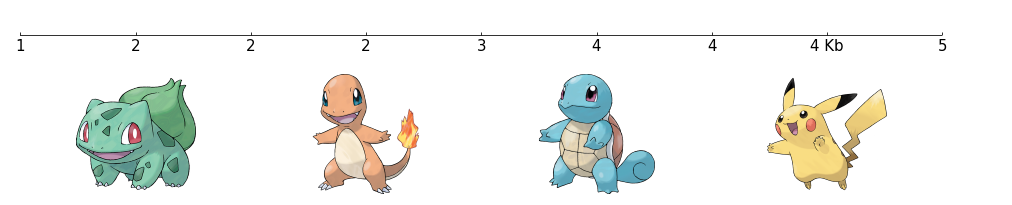

In [6]:
# plot region
frame.plot("chr1:1000-5000")